### Handle Imports

In [24]:
import torch
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import pprint

### Check if PyTorch recognizes GPU

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Read in dataset

In [27]:
columns = [
    'id', 'label', 'claim', 'subject', 'speaker', 'speaker_job_title', 'state_info',
    'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

# read in original LIAR dataset
df_train = pd.read_csv('../data/LIAR/train.tsv', sep='\t', names=columns).dropna()
df_valid = pd.read_csv('../data/LIAR/valid.tsv', sep='\t', names=columns)
df_test = pd.read_csv('../data/LIAR/test.tsv', sep='\t', names=columns)

### Tokenize Input Data

In [28]:
def tokenize_liar(samples, labels, tokenizer):
  tokenized = []
  for idx in range(len(samples)):
    tokenized_claim = tokenizer(samples[idx], padding=True, max_length=128, return_tensors='pt')
    
    n_inst = {
      'claim_token': tokenized_claim,
      'claim_origin': samples[idx],
      'label': labels[idx], 
      'idx': idx
    }
    tokenized.append(n_inst)

  return tokenized

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

#LIAR Code:
# obtain training samples/label pairs from dataset
liar_train_samples = df_train['claim'].to_list()
liar_train_labels = df_train['label'].to_list()
liar_valid_samples = df_train['claim'].to_list()
liar_valid_labels = df_train['label'].to_list()
liar_test_samples = df_test['claim'].to_list()
liar_test_labels = df_test['label'].to_list()

train_encoded = tokenizer(liar_train_samples, padding='max_length', truncation=True, max_length=49, return_tensors='pt')
valid_encoded = tokenizer(liar_valid_samples, padding='max_length', truncation=True, max_length=49, return_tensors='pt')
test_encoded = tokenizer(liar_test_samples, padding='max_length', truncation=True, max_length=49, return_tensors='pt')

### Define PyTorch Datasets (Augmented using SMOTE & Unaugmented)

In [30]:
from torch.utils.data import Dataset

class LiarDataset(Dataset):
    def __init__(self, liar_encodings, labels):
        self.labels = labels
        self.encodings = liar_encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx]),
        }

### Segment Dataset into training and test portions

In [31]:
label_map = {
            'pants-fire': 0,
            'false': 0,
            'barely-true': 0,
            'half-true': 0,
            'mostly-true': 1,
            'true': 1
        }

train_labels = [label_map[inst] for inst in liar_train_labels]
valid_labels = [label_map[inst] for inst in liar_valid_labels]
test_labels = [label_map[inst] for inst in liar_test_labels]


train_dataset = LiarDataset(train_encoded, train_labels)
valid_dataset = LiarDataset(valid_encoded, valid_labels)
test_dataset = LiarDataset(test_encoded, test_labels)

### Define model, dataloaders, loss function, collate function, and optimizer

In [32]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from collections import Counter

# change num_labels in accordance with current problem design (binary or multi-class classification)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

# display model embedding size
embedding_size = model.config.hidden_size
print(f"Embedding size 'E': {embedding_size}")

# freeze base model layers
for param in model.base_model.parameters():
    param.requires_grad = False

# unfreeze last two layers of base model for fine tuning
#for param in model.base_model.encoder.layer[-2:]:
#    param.requires_grad = True

# attempt to use class weights to offset imbalance of dataset
label_counts = Counter(liar_train_labels)
label_map = {
            'pants-fire': 0,
            'false': 0,
            'barely-true': 0,
            'half-true': 0,
            'mostly-true': 1,
            'true': 1
        }
numeric_labels = np.array(train_labels)
true_count = np.count_nonzero(numeric_labels == 1)
false_count = np.count_nonzero(numeric_labels == 0)
total_count = len(train_dataset)
true_weight = total_count / true_count
false_weight = total_count / false_count
print(f'Weights: \nFalse: {false_weight}\nTrue: {true_weight}')

class_weights = torch.tensor([false_weight, true_weight]).to(device)

loss_fn = CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=data_collator)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding size 'E': 768
Weights: 
False: 1.5983353151010702
True: 2.6713036565977744


### Define training loop

In [10]:
def train_covid(model, optim, loss_fn, dataloader, epochs):
#def train_covid(model, optim, dataloader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(dataloader):
            # send claim dict's values and label to device
            batch = {key: value.to(device) for key, value in batch.items()}

            # forward pass on BERT
            outputs = model(**batch)
            logits = outputs.logits

            # class weighted CrossEntropyLoss
            loss = loss_fn(logits, batch['labels'])

            # loss provided by model
            #loss = outputs.loss 

            optim.zero_grad()

            # backwards pass on BERT
            loss.backward()
            optim.step()

            total_loss += loss.item()

            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")
    print(f"Epoch {epoch + 1}, Loss: {total_loss}")

In [10]:
print(model.config.num_labels)

2


### Train model for sequence classification

In [ ]:
epochs = 27
train_covid(model, optimizer, loss_fn, train_dataloader, epochs)
#train_covid(model, optimizer, train_dataloader, epochs)

### Save Model Weights

In [13]:
torch.save(model.state_dict(), f'./models/model_weights28.pth')

### Load Model Weights

In [43]:
model.load_state_dict(torch.load('./models/model_weights-best.pth'))

C:\Users\asubedi\AppData\Local\Temp\ipykernel_396296\2191956140.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/model_weights-

<All keys matched successfully>

### Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            
            batch = {key: value.to(device) for key, value in batch.items()}
            
            # run sequences through BERT
            outputs = model(**batch)
            
            # highest energy class is our prediction
            logits = outputs.logits
            preds = torch.argmax(logits, 1)
            
            labels = batch['labels']

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    class_labels = [0, 1]
    per_class_accuracy = {}
    for class_label in class_labels:
        # get indices which match current class_label
        class_indices = np.where(np.array(all_labels) == class_label)[0]
        
        # get predictions of current class label
        class_preds = np.array(all_preds)[class_indices]
        
        # calculate accuracy for current class_label
        correct_class_preds = np.sum(class_preds == class_label)
        total_class_samples = len(class_indices)
        
        per_class_accuracy[class_label] = (correct_class_preds / total_class_samples) * 100
        
    accuracy = 100*accuracy_score(all_labels, all_preds)
    precision = 100*precision_score(all_labels, all_preds, labels=class_labels, average=None, zero_division=0)
    recall = 100*recall_score(all_labels, all_preds, labels=class_labels, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, labels=class_labels, average=None, zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds, labels=class_labels)

    return accuracy, precision, recall, f1, per_class_accuracy, conf_mat


# evaluate the model on the test set (unaugmented)
accuracy, precision, recall, f1, per_class_accuracy, conf_mat = evaluate_model(model, test_dataloader)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Per Class Accuracy: {per_class_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(conf_mat)

# validation metrics check
# print('------')
# accuracy, precision, recall, f1, per_class_accuracy, conf_mat = evaluate_model(model, valid_dataloader)

# print(f"Test Accuracy: {accuracy:.2f}%")
# print(f"Per Class Accuracy: {per_class_accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1: {f1}")
# print(conf_mat)

C:\Users\asubedi\AppData\Local\Temp\ipykernel_396296\2781182478.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
C:\Users\asubedi\AppData\Local\Temp\ipykernel_396296\2781182478.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),


Test Accuracy: 57.70%
Per Class Accuracy: {0: 58.43520782396088, 1: 56.347438752783965}
Precision: [70.91988131 42.66441821]
Recall: [58.43520782 56.34743875]
F1: [0.64075067 0.48560461]
[[478 340]
 [196 253]]


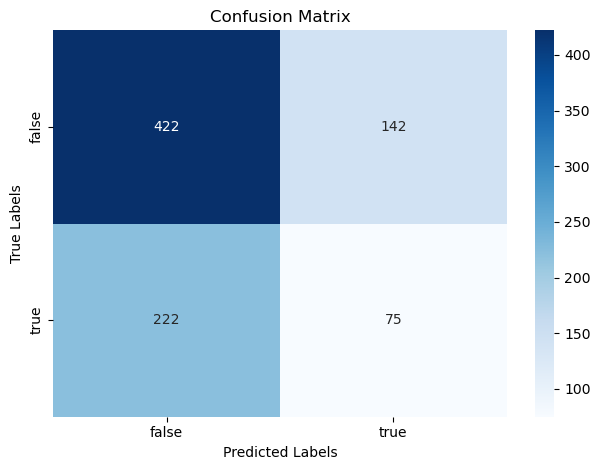

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['false', 'true']

def plot_confusion_matrix(conf_matrix, class_labels):
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

print("\n")
plot_confusion_matrix(conf_mat, class_labels)